# Random Forest

## Data Preprocessing

In [16]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict

# Set working directory
month_file = '2_June'
# Set working directory
os.chdir("/Users/mau/Library/CloudStorage/Dropbox/Mac/Documents/Dissertation/Chapter 2/Entire_Data/By month/"+month_file+"/Ending Balances/Per_Player")

In [17]:
# Filter Columns
filter = ['session_time', 'gender', 'age_gen', 'day', 'timeofday', 'first_outcome',
        'first_wager','first_p/b', 'last_outcome', 'last_wager', 'last_p/b',
        'beginning_amt', 'ending_amt', 'ending_balance', 'ave_slotdenom', 
        'std_slotdenom', 'min_slotdenom', 'max_slotdenom', 'ave_theo_payback',
        'min_theo_payback', 'max_theo_payback', 'ave_wageramt', 'std_wageramt',
        'min_wager', 'max_wager', 'ave_p/b', 'std_p/b', 'max_p/b', 'max_profit', 'depletion_slope', 
        '#inc_slotdenom', '#dec_slotdenom', '#inc_maxbet', '#dec_maxbet',
        'w/min', 'l/min', 'nh/min', 'd/min', '2ws_profit', '2ws_wgramt','2ws/min', 
        '3ws_profit', '3ws_wgramt', '3ws/min', '4ws_profit', '4ws_wgramt', '4ws/min', 
        'w/g', 'l/g', 'nh/g', 'd/g', 'ave_time_per_gamble',
        'min_time_per_gamble', 'machines_changes', 'unique_machines', 'classification']

# Load dataset
dataset = pd.read_parquet('top_vs_ntop_player_ending_balance_by_session.parquet', columns=filter)

# Keep only session_time 1
dataset = dataset[dataset['session_time'] == 1]
# Drop age_range and playerkey
dataset = dataset.drop(['session_time'], axis=1)

## Load Dataframes

In [18]:
# Convert 'ave_time_per_machine' to seconds

# # Seperate dependent and independent variables
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Econde gender column (Binary)
le = LabelEncoder()

# Binary Encode gender and simplay
X[:, 0] = le.fit_transform(X[:, 0])

# # Encode age_generartion, day, time of day,  and time of day columns, first_outcome, and last_outcome.
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1, 2, 3, 4, 7])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

y = le.fit_transform(y)

## Handling Class Imbalance 
# Apply SMOTE - SMOTE generates synthetic samples for the minority class to balance the dataset:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size = 0.2, random_state = 1)

sc = StandardScaler()

# Scale all columns except the encoded ones
X_train[:, 19:] = sc.fit_transform(X_train[:, 19:])
X_test[:, 19:] = sc.transform(X_test[:, 19:])

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='macro', zero_division=1))
print('Recall: ', recall_score(y_test, y_pred, average='macro'))
print('F1 Score: ', f1_score(y_test, y_pred, average='macro'))

[[33  3]
 [ 2 58]]
Accuracy:  0.9479166666666666
Precision:  0.9468384074941452
Recall:  0.9416666666666667
F1 Score:  0.9441275753695728


## Cumulative Accuracy Profile (CAP) Graph

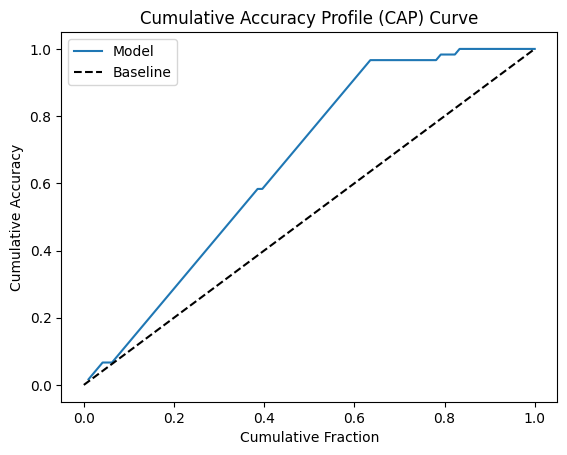

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the predicted probabilities or scores named 'predicted_scores' and true labels named 'true_labels'

# Sort the scores and corresponding true labels
sorted_indices = np.argsort(y_pred)[::-1]
sorted_true_labels = y_test[sorted_indices]

# Calculate cumulative metrics
total_positive = np.sum(y_test)
cumulative_positives = np.cumsum(sorted_true_labels)
cumulative_accuracy = cumulative_positives / total_positive
cumulative_fraction = np.arange(1, len(sorted_true_labels) + 1) / len(sorted_true_labels)

# Create the CAP curve plot
plt.plot(cumulative_fraction, cumulative_accuracy, label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlabel('Cumulative Fraction')
plt.ylabel('Cumulative Accuracy')
plt.title('Cumulative Accuracy Profile (CAP) Curve')
plt.legend()
plt.show()

## Hyperparameter Tuning

In [20]:
# Define the hyperparameters and their respective ranges
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=0)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the data to perform the search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='macro', zero_division=1))
print('Recall:', recall_score(y_test, y_pred, average='macro'))
print('F1 Score:', f1_score(y_test, y_pred, average='macro'))

# Print the best hyperparameters
print('Best Hyperparameters:', best_params)

Confusion Matrix:
[[34  2]
 [ 2 58]]
Accuracy: 0.9583333333333334
Precision: 0.9555555555555555
Recall: 0.9555555555555555
F1 Score: 0.9555555555555555
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


## Cross Validation

In [21]:
# Seperate dependent and independent variables
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Encode gender column (Binary)
le = LabelEncoder()
X[:, 0] = le.fit_transform(X[:, 0])

# Encode categorical columns
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1, 2, 3, 4, 7])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
y = le.fit_transform(y)

# Handling Class Imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_resampled[:, 19:] = sc.fit_transform(X_resampled[:, 19:])

# Best hyperparameters from tuning
best_hyperparameters = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

# Initialize logistic regression model with best hyperparameters
classifier = RandomForestClassifier(random_state=0, **best_hyperparameters)

# Perform cross-validation
y_pred_cv = cross_val_predict(classifier, X_resampled, y_resampled, cv=10)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(classifier, X_resampled, y_resampled, cv=10, scoring='accuracy')
mean_accuracy = cv_scores.mean()
std_accuracy = cv_scores.std()

# Calculate precision, recall, and F1-score
precision = precision_score(y_resampled, y_pred_cv, average='macro')
recall = recall_score(y_resampled, y_pred_cv, average='macro')
f1 = f1_score(y_resampled, y_pred_cv, average='macro')

# Print the metricsvr
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_resampled, y_pred_cv)
print("Confusion Matrix:")
print(conf_matrix)

Cross-Validation Scores: [0.85416667 0.97916667 1.         1.         0.95833333 1.
 0.95833333 0.95833333 1.         0.95744681]
Mean Accuracy: 0.9665780141843971
Standard Deviation of Accuracy: 0.04189296476685428
Precision: 0.9665598683404241
Recall: 0.9665271966527196
F1 Score: 0.9665266106442576
Confusion Matrix:
[[232   7]
 [  9 230]]


In [22]:
results = ['Random Forest', mean_accuracy, std_accuracy, precision, recall, f1]
columns = ['Model', 'Mean Accuracy', 'Std of Accuracy', 'Precision', 'Recall', 'F1 Score']
results_df = pd.DataFrame([results], columns=columns)

# Print the results as a LaTeX table
latex_table = results_df.to_latex(index=False, escape=False)
print(latex_table)

\begin{tabular}{lrrrrr}
\toprule
        Model &  Mean Accuracy &  Std of Accuracy &  Precision &   Recall &  F1 Score \\
\midrule
Random Forest &       0.966578 &         0.041893 &    0.96656 & 0.966527 &  0.966527 \\
\bottomrule
\end{tabular}



/var/folders/vp/1skwx2kd29s4fxnxx7tt9r6w0000gn/T/ipykernel_44979/3783961505.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = results_df.to_latex(index=False, escape=False)


Text(0.5, 1.0, 'Cumulative Accuracy Profile (CAP) Curve')

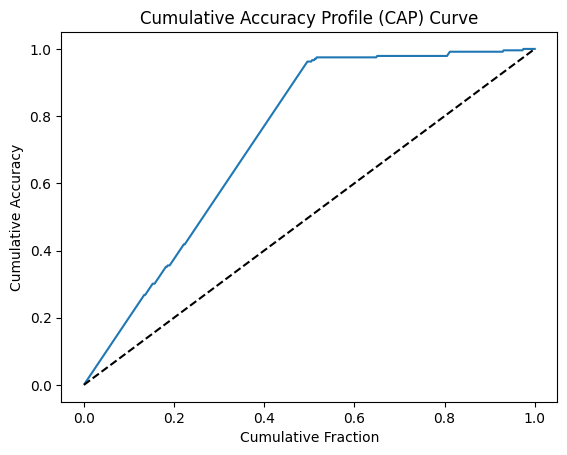

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the predicted probabilities or scores named 'predicted_scores' and true labels named 'true_labels'

# Sort the scores and corresponding true labels
sorted_indices = np.argsort(y_pred_cv)[::-1]
sorted_true_labels = y_resampled[sorted_indices]

# Calculate cumulative metrics
total_positive = np.sum(y_resampled)
cumulative_positives = np.cumsum(sorted_true_labels)
cumulative_accuracy = cumulative_positives / total_positive
cumulative_fraction = np.arange(1, len(sorted_true_labels) + 1) / len(sorted_true_labels)

# Create the CAP curve plot
plt.plot(cumulative_fraction, cumulative_accuracy, label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlabel('Cumulative Fraction')
plt.ylabel('Cumulative Accuracy')
plt.title('Cumulative Accuracy Profile (CAP) Curve')

## Feature Importance

In [30]:
from sklearn.inspection import permutation_importance

result = permutation_importance(classifier, X_resampled, y_resampled, n_repeats=10, random_state=42)

# Extract feature coefficients (importance)
feature_importance = result.importances_mean

# Modify the get_feature_names_out function to exclude 'remainder__'
def get_feature_names_without_prefix(transformer, input_features=None):
    return [f.split('remainder__')[-1] for f in transformer.get_feature_names_out(input_features)]

# Get the feature names without 'remainder__' prefix
feature_names = get_feature_names_without_prefix(ct, input_features=dataset.columns)
coefs_with_names = list(zip(feature_names, feature_importance))

# Sort coefficients by magnitude (absolute value) in descending order
coefs_with_names.sort(key=lambda x: abs(x[1]), reverse=True)

# Print feature importance
print("Feature Importance (Top features with highest absolute coefficients):")
for feature, coef in coefs_with_names:
    print(f"{feature}: {coef}")

Feature Importance (Top features with highest absolute coefficients):
encoder__timeofday_night: 0.003138075313807498
max_p/b: 0.001464435146443499
min_time_per_gamble: 0.001464435146443499
unique_machines: 0.001464435146443499
#dec_maxbet: 0.001255230125522999
machines_changes: 0.001255230125522999
3ws/min: 0.00020920502092049986
encoder__age_gen_Baby Boomers: 0.0
encoder__age_gen_Gen X: 0.0
encoder__age_gen_Gen Z: 0.0
encoder__age_gen_Millenials: 0.0
encoder__age_gen_Silent: 0.0
encoder__day_1.0: 0.0
encoder__timeofday_afternoon: 0.0
encoder__timeofday_evening: 0.0
encoder__timeofday_morning: 0.0
encoder__first_outcome_draw: 0.0
encoder__first_outcome_gain: 0.0
encoder__first_outcome_loss: 0.0
encoder__first_outcome_near-hit: 0.0
encoder__last_outcome_draw: 0.0
encoder__last_outcome_gain: 0.0
encoder__last_outcome_loss: 0.0
encoder__last_outcome_near-hit: 0.0
gender: 0.0
first_wager: 0.0
first_p/b: 0.0
last_wager: 0.0
last_p/b: 0.0
beginning_amt: 0.0
ending_amt: 0.0
ending_balance: 0.